## MO444 Project 3 - Reinforcement Learning

* Rodrigo Araújo Marinho Franco - RA: 233569
* Felipe Marinho Tavares - RA: 265680

### Contributions:
* Rodrigo
 * Reinforcement Learning Model
* Felipe
 * Evolutionary Model

# PART I - Evolutionary Model

• The evolutionary model adopted:

Algoritmo genético modificando. 

Uso de 11 features para decisão de cada ação.

Features:

1. food_near
2. distance_closest_food  / layout_width
2. distance_closest_food  / layout_height
3. distance_closest_ghost / layout_width
3. distance_closest_ghost / layout_height
4. ghost_near_1 
5. ghost_near_2
6. safe_eat
7. distance_closest_capsule / layout_width
7. distance_closest_capsule / layout_height
8. is_scared

Os indivíduos da população carregam pesos para serem multiplicados para cada uma das 11 features, e pesos para serem multiplicados para cada uma das 5 possíveis ações de movimento no labirinto (North, South, East, West, Stop), total de 55 genes, 11 (features) * 5 (possíveis direções de movimento). Assim, cada gene dos individuos são pesos correspondentes a uma feature e a uma ação.

Para cada ação no labirinto são multiplicados os pesos carregados pelo individuo e considerada a ação (seja a ação possível) com maior valor resultante.

• Variations on parameters
  * "population_size": Tamanho da população (40 individuos)
  * "gene_size": Tamanho do gene do individuo
  * "n_offspring": Número de indivíduos gerados por cruzamento
  * "n_crossover_genes": Número de genes considerados no cruzamento
  * "n_mutation": Número de indivíduos afetados por mutações do pool de novos indivíduos gerados por cruzamento
  * "n_mutation_genes": Número de genes mutados por indivíduo

• Fitness function adopted:

Score do próprio jogo

• Stop criteria

Paciencia de 10 gerações sem melhoria de score médio da população

• Selection technique:

Individuos gerados por crossover, gerados dos melhores, e dos restantes melhores até encher o tamanho da população.

• Crossover technique

Escolha de N genes dos indivíduos pais. (Parametro `n_crossover_genes`.)

• Mutation technique

Mutação de N individuos resultantes de crossover (param. `n_mutation`), em n genes (param. `n_mutation_genes`).

• Replacement method

Para cada geração as populações são atualizadas escolhendo individuos por crossover, em ordem dos melhores, e dentre os novos indíviduos por crossover feito mutações em genes.

• Mutation rate:

25% da população

• Crossover rate

50% da população

In [1]:
import sys
sys.path.append("search/")

#import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import environment

from importlib import reload
reload(environment)

<module 'environment' from 'search/environment.py'>

In [2]:
def generate_individual_gene():
    abs = 1
    return random.uniform(-abs, abs)

individual_global_id = 0
def get_individual_id():
    global individual_global_id
    individual_global_id += 1
    return individual_global_id

def new_population(population_size, gene_size=11):
    population = []
    for i in range(population_size):
        gene = []
        for i in range(gene_size):
            gene.append(generate_individual_gene())
        individual = {
            'id': get_individual_id(),
            'gene': np.array(gene),
            'fitness': -1,
        }
        population.append(individual)
    return np.array(population)

def genetic_algorithm(layout, params, n_episodes=25000, print_every=100, patience=1500, print_steps=False):
    
    # create population
    population = new_population(params['population_size'], gene_size=params['gene_size'])
    
    # create environment to run game and agents
    env = environment.Environment(params,
                                  pacman_algorithm="GA",
                                  layout=layout,
                                  use_features=True,
                                  print_steps=print_steps)
    
    # variables to save generational results
    l_results = []
    best_score = {
        "episode_number": -1,
        "average_score": -1000.0,
        "average_num_actions": 0,
        "average_num_foods_eaten": 0,
        "winrate": 0.0
    }

    print("Starting agent training...")
    for i_episode in range(1, n_episodes + 1):
        
        #if debug:
        #    print(f"generation {i_episode} \npopulation\n{population}\n")
        
        for i in range(len(population)):
            env.pacman.individual = population[i]['gene']
            
            # reset and run environment for individual
            env.reset()
            while not env.done():
                env.step()

            average_score, average_reward, average_foods_eaten, average_num_actions, winrate = env.compute_scores()

            # update individual fitness
            population[i]['fitness'] = average_score
            
            result_record = {
                "episode_number": i_episode,
                "individual_id": population[i]['id'],
                "average_score": average_score,
                "average_reward": average_reward,
                "average_num_actions": average_num_actions,
                "average_num_foods_eaten": average_foods_eaten,
                "winrate": winrate,
            }
            l_results.append(result_record)

            if average_score > best_score["average_score"]:
                checkpoints_without_improvement = 0
                best_score["episode_number"] = i_episode
                best_score["average_score"] = average_score
                best_score["average_reward"] = average_reward
                best_score["average_num_actions"] = average_num_actions
                best_score["average_num_foods_eaten"] = average_foods_eaten
                best_score["winrate"] = winrate
        
        if i_episode == 1 or i_episode % print_every == 0:
            print("Generation: ", i_episode, end=" ")
            print('Avg score: {:.2f}'.format(average_score), end=" ")
            print('Avg reward: {:.2f}'.format(average_reward), end=" ")
            print('Avg n. of actions: {:.2f}'.format(average_num_actions), end=" ")
            print('Avg n. of food eaten: {:.2f}/{:}'.format(average_foods_eaten, env.layout.totalFood), end=" ")
            print('Winrate: {:.2f}%'.format(winrate))

        if i_episode < n_episodes:
            # sort population by individual fitness
            population = sorted(population, key=lambda k: k['fitness'], reverse=True)

            # crossover
            new_descendents = []
            if params['n_offspring'] != 0:
                # loop to create offsprings
                for parent_id in range(params['n_offspring']): 
                    # select genes from parent1
                    for i in range(params['n_crossover_genes']):
                        parent1_genes = []

                        gene_id = round(random.random() * (params['gene_size'] - 1))
                        #while gene_id in parent1_genes:
                        #    gene_id = round(random.random() * (params['gene_size'] - 1))

                        parent1_genes.append(gene_id)
                    # instanciate offspring data
                    offspring = population[parent_id].copy()
                    offspring['id'] = get_individual_id()
                    # select genes from parent2
                    for gene_id in range(params['gene_size']):
                        if gene_id not in parent1_genes:
                            offspring[gene_id] = population[parent_id+1].copy()
                    new_descendents.append(offspring)

                # mutation of crossover descedents
                if params['n_mutation'] != 0:
                    for offspring in new_descendents[:params['n_mutation']]:
                        # select genes for mutation
                        for i in range(params['n_mutation_genes']):
                            mutation_genes = []

                            gene_id = round(random.random() * (params['gene_size'] - 1))
                            #while gene_id in mutation_genes:
                            #    gene_id = round(random.random() * (params['gene_size'] - 1))

                            offspring['gene'][gene_id] = generate_individual_gene()
                            offspring['fitness'] = np.NaN

            if debug:
                print(f"generation {i_episode} after \npopulation\n{[i['fitness'] for i in population]}\n")
                            
            # replace population for next generation; append elites, offspring, and the rest
            next_population = population[:params['n_elites']] \
                         + new_descendents \
                         + population[(params['n_elites'] + params['n_offspring']):]
            population = next_population
            assert len(population) == params['population_size']

    print("Training done!")
    print()
    #print("Metrics from the episode with the best score:")
    #print(best_score)

    return env, l_results

In [3]:
def plot_evolution(best, avg, worst):
    plt.figure(figsize=(16, 6))
    plt.title("Scores per generation")
    plt.xlabel('Generations')
    plt.ylabel('Score (from the game)')
    plt.plot(best, label='Best scores')
    plt.plot(avg, label='Average scores')
    plt.plot(worst, label='Worst scores')
    plt.show()

In [4]:
params = {
    "population_size": 40,
    "gene_size": 55, # 11 (features) * 5 (actions)
    "n_elites": 5,
    "n_offspring": 20,
    "n_crossover_genes": 21,
    "n_mutation": 10,
    "n_mutation_genes": 5,
}

n_episodes = 20 # Number of episodes/generations for the genetic algorithm agent
print_every = 1   # episodes/generations
patience = 10   # Max number episodes/generations without a improvement tolerated

print_steps=False
debug=False

Initial state of the environment looks like:


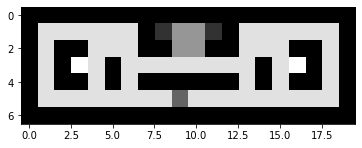

Layout Height:  7
Layout Width:  20

Starting agent training...
Generation:  1 Avg score: -425.90 Avg reward: 35.10 Avg n. of actions: 48.15 Avg n. of food eaten: 11.68/55 Winrate: 0.00%
Generation:  2 Avg score: -426.82 Avg reward: 35.14 Avg n. of actions: 46.70 Avg n. of food eaten: 11.66/55 Winrate: 0.00%
Generation:  3 Avg score: -425.75 Avg reward: 35.48 Avg n. of actions: 42.45 Avg n. of food eaten: 11.40/55 Winrate: 0.00%
Generation:  4 Avg score: -433.99 Avg reward: 26.54 Avg n. of actions: 41.39 Avg n. of food eaten: 10.63/55 Winrate: 0.00%
Generation:  5 Avg score: -435.36 Avg reward: 23.63 Avg n. of actions: 43.16 Avg n. of food eaten: 10.48/55 Winrate: 0.00%
Generation:  6 Avg score: -441.36 Avg reward: 16.30 Avg n. of actions: 51.66 Avg n. of food eaten: 10.54/55 Winrate: 0.00%
Generation:  7 Avg score: -438.98 Avg reward: 18.54 Avg n. of actions: 50.18 Avg n. of food eaten: 10.47/55 Winrate: 0.00%
Generation:  8 Avg score: -435.88 Avg reward: 23.25 Avg n. of actions: 50.6

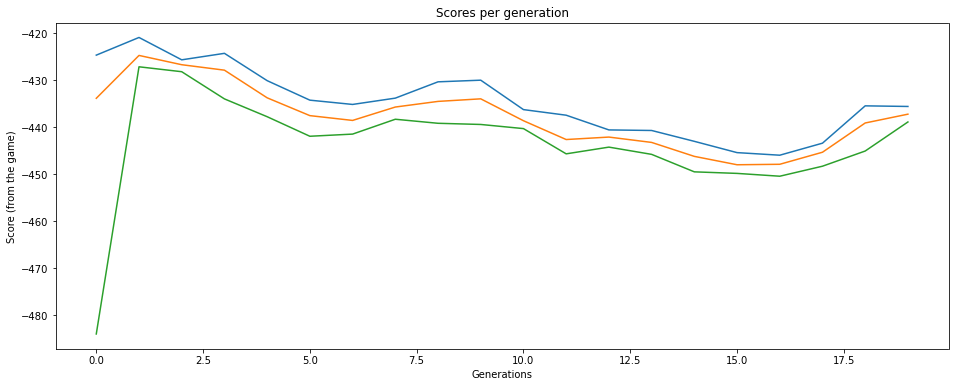

In [5]:
layout = "smallClassic"
env, results = genetic_algorithm(layout, params, n_episodes, print_every, patience, print_steps)

best_scores = []
avg_scores = []
worst_scores = []

df = pd.DataFrame.from_records(results)
for i in range(1, n_episodes+1):
    scores = df[df['episode_number'] == i]['average_score']
    best_scores.append(scores.max())
    avg_scores.append(scores.mean())
    worst_scores.append(scores.min())
plot_evolution(best_scores, avg_scores, worst_scores)

Initial state of the environment looks like:


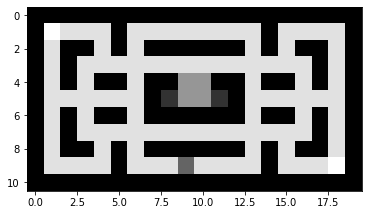

Layout Height:  11
Layout Width:  20

Starting agent training...
Generation:  1 Avg score: -437.32 Avg reward: 16.65 Avg n. of actions: 62.33 Avg n. of food eaten: 10.82/97 Winrate: 0.00%
Generation:  2 Avg score: -449.95 Avg reward: 6.67 Avg n. of actions: 74.08 Avg n. of food eaten: 11.28/97 Winrate: 0.00%
Generation:  3 Avg score: -461.06 Avg reward: -1.43 Avg n. of actions: 76.36 Avg n. of food eaten: 10.85/97 Winrate: 0.00%
Generation:  4 Avg score: -455.70 Avg reward: 3.70 Avg n. of actions: 76.50 Avg n. of food eaten: 11.19/97 Winrate: 0.00%
Generation:  5 Avg score: -444.39 Avg reward: 6.61 Avg n. of actions: 67.89 Avg n. of food eaten: 10.44/97 Winrate: 0.00%
Generation:  6 Avg score: -431.14 Avg reward: 18.18 Avg n. of actions: 62.84 Avg n. of food eaten: 10.94/97 Winrate: 0.00%
Generation:  7 Avg score: -432.39 Avg reward: 26.93 Avg n. of actions: 68.09 Avg n. of food eaten: 12.12/97 Winrate: 0.00%
Generation:  8 Avg score: -427.58 Avg reward: 38.04 Avg n. of actions: 72.78 

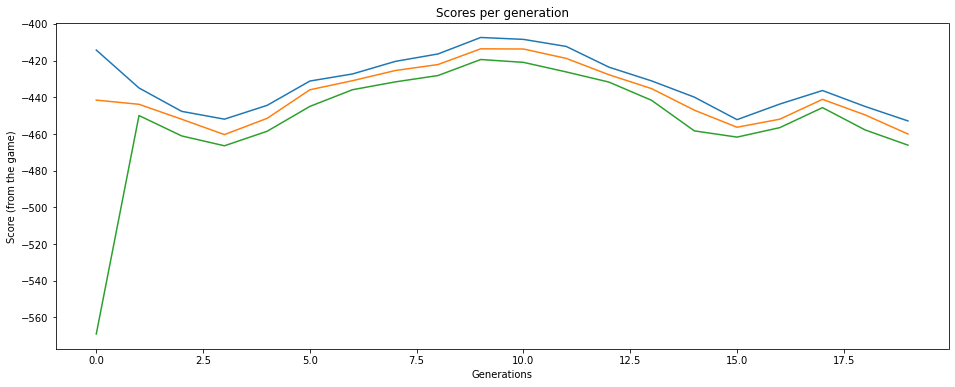

In [6]:
layout = "mediumClassic"
env, results = genetic_algorithm(layout, params, n_episodes, print_every, patience, print_steps)

best_scores = []
avg_scores = []
worst_scores = []

df = pd.DataFrame.from_records(results)
for i in range(1, n_episodes+1):
    scores = df[df['episode_number'] == i]['average_score']
    best_scores.append(scores.max())
    avg_scores.append(scores.mean())
    worst_scores.append(scores.min())
plot_evolution(best_scores, avg_scores, worst_scores)

Initial state of the environment looks like:


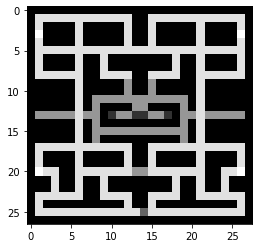

Layout Height:  27
Layout Width:  28

Starting agent training...
Generation:  1 Avg score: -451.85 Avg reward: 16.12 Avg n. of actions: 130.85 Avg n. of food eaten: 17.70/229 Winrate: 0.00%
Generation:  2 Avg score: -463.43 Avg reward: 5.60 Avg n. of actions: 151.55 Avg n. of food eaten: 18.62/229 Winrate: 0.00%
Generation:  3 Avg score: -459.21 Avg reward: 9.73 Avg n. of actions: 145.31 Avg n. of food eaten: 18.41/229 Winrate: 0.00%
Generation:  4 Avg score: -450.24 Avg reward: 16.78 Avg n. of actions: 129.94 Avg n. of food eaten: 17.70/229 Winrate: 0.00%
Generation:  5 Avg score: -447.43 Avg reward: 13.61 Avg n. of actions: 137.13 Avg n. of food eaten: 17.88/229 Winrate: 0.00%
Generation:  6 Avg score: -442.54 Avg reward: 18.64 Avg n. of actions: 136.64 Avg n. of food eaten: 18.20/229 Winrate: 0.00%
Generation:  7 Avg score: -450.42 Avg reward: 7.95 Avg n. of actions: 149.82 Avg n. of food eaten: 18.38/229 Winrate: 0.00%
Generation:  8 Avg score: -455.80 Avg reward: 3.51 Avg n. of ac

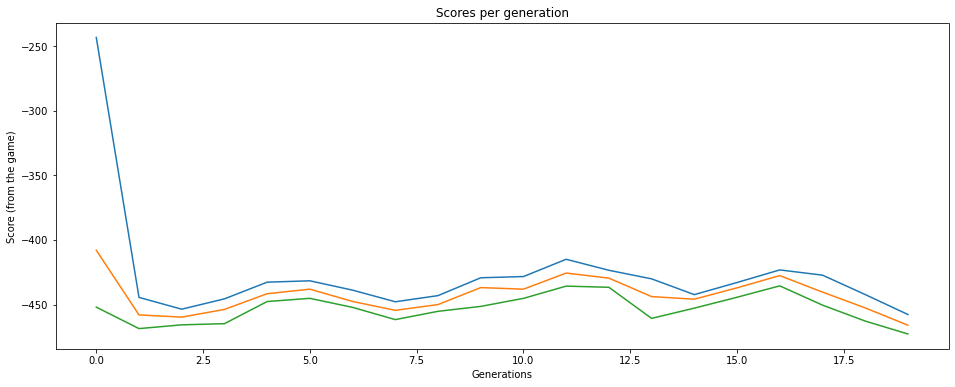

In [7]:
layout = "originalClassic"
env, results = genetic_algorithm(layout, params, n_episodes, print_every, patience, print_steps)

best_scores = []
avg_scores = []
worst_scores = []

df = pd.DataFrame.from_records(results)
for i in range(1, n_episodes+1):
    scores = df[df['episode_number'] == i]['average_score']
    best_scores.append(scores.max())
    avg_scores.append(scores.mean())
    worst_scores.append(scores.min())
plot_evolution(best_scores, avg_scores, worst_scores)

**Discussão**

